In [1]:
import pickle
from pathlib import Path
from easydict import EasyDict
import pandas as pd
from matplotlib import pyplot as plt
from ml import train
from dataloading import get_data, build_features


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

cfgs, btests = [], []
for p in sorted(Path("optimization").glob("*.pickle")):
    cfg, btest = pickle.load(open(p, "rb"))
    cfgs.append(cfg)
    btests.append(btest)
    print(p)

optimization/btest000.pickle
optimization/btest001.pickle


In [2]:
from backtest import DataParser, MovingWindow
import numpy as np


fsize = 32
tfdict = {"M5":0, "M15":1, "H1":2}
X, y, poslist = [], [], []
for btest in btests:
    print(btest.cfg.ticker, end=" ")
    hist_pd, hist = DataParser(btest.cfg).load()
    mw = MovingWindow(hist, fsize+2)
    print(len(btest.positions))
    for pos in btest.positions[2:]:
        f, _ = mw(pos.open_indx)
        x = build_features(f, 
                           pos.dir, 
                           btest.cfg.stops_processor.func.cfg.sl, 
                           btest.cfg.trailing_stop_rate,
                           pos.open_date, 
                           tfdict[btest.cfg.period])
        X.append([x])
        y.append(pos.profit)
        poslist.append(pos)
        
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)
print(X.shape, y.shape)
print(f"{X[0, 0, -2, 0]:8.0f} -> {X[-1, 0, -2, 0]:8.0f}")

BTCUSD 465
ETHUSD 550
(1011, 1, 9, 32) (1011,)
20180522 -> 20231016


(758, 1, 7, 32) (253, 1, 7, 32) (253,)
117.14505


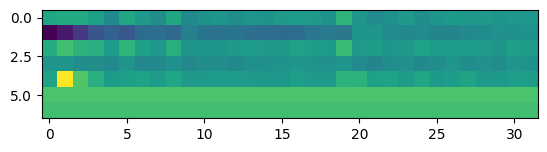

In [9]:
def get_data(X, y, test_split=0.25):
    ids = np.arange(X.shape[0])
    # np.random.shuffle(ids)
    test_size = int(X.shape[0]*test_split)
    ids_test, odates_testset, odates = [], set(), X[:, 0, -2, 0]
    while len(ids_test) < test_size:
        ix = np.random.randint(0, X.shape[0])
        d = odates[ix]
        if d not in odates_testset:
            ii = ids[odates == d]
            ids_test += ii.tolist()
            odates_testset.add(d)
    ids_train = [ix for ix in ids if ix not in ids_test]   
    np.random.shuffle(ids_train) 
    np.random.shuffle(ids_test) 
        
    # ids_test, ids_train = ids[:test_size], ids[test_size:]
    X_train, X_test, y_train, y_test, profs_test = X[ids_train], X[ids_test], y[ids_train], y[ids_test], y[ids_test].copy()
    tf_test = X_test[:, 0, -1, 0]
    X_train = X_train[:, :, :-2, :]
    X_test = X_test[:, :, :-2, :]
    
    y_train = np.tanh(y_train)
    y_test = np.tanh(y_test)
    
    return X_train, X_test, y_train, y_test, profs_test.copy(), tf_test
X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y)
print(X_train.shape, X_test.shape, tf_test.shape)
plt.imshow(X_train[0][0][:])
print(profs_test.sum())

In [18]:
np.random.seed(i)
X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y, test_split_size)
profs_test.sum()

-79.89423

0.0
[001,    32] loss train: 0.8442 | test: nan
[002,    32] loss train: 0.8221 | test: nan
[003,    32] loss train: 0.8110 | test: nan
[004,    32] loss train: 0.8009 | test: nan
[005,    32] loss train: 0.8092 | test: nan


/home/andrybin/miniconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([0])) that is different to the input size (torch.Size([0, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[006,    32] loss train: 0.8153 | test: nan
[007,    32] loss train: 0.7987 | test: nan
[008,    32] loss train: 0.8004 | test: nan
[009,    32] loss train: 0.7946 | test: nan
[010,    32] loss train: 0.7975 | test: nan
[011,    32] loss train: 0.7911 | test: nan
[012,    32] loss train: 0.7798 | test: nan
[013,    32] loss train: 0.7978 | test: nan
[014,    32] loss train: 0.7943 | test: nan
[015,    32] loss train: 0.7935 | test: nan
[016,    32] loss train: 0.7992 | test: nan
[017,    32] loss train: 0.7943 | test: nan
[018,    32] loss train: 0.7961 | test: nan
[019,    32] loss train: 0.8034 | test: nan
[020,    32] loss train: 0.7839 | test: nan
[021,    32] loss train: 0.7985 | test: nan
[022,    32] loss train: 0.7896 | test: nan
[023,    32] loss train: 0.7790 | test: nan
[024,    32] loss train: 0.7931 | test: nan
[025,    32] loss train: 0.7786 | test: nan
[026,    32] loss train: 0.7857 | test: nan
[027,    32] loss train: 0.7852 | test: nan
[028,    32] loss train: 0.7696 

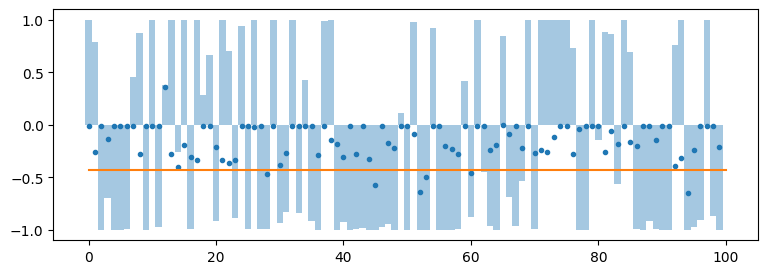

In [29]:
from sklearn.metrics import mean_absolute_error, f1_score
import torch
device = "cuda"

nitrers = 1
test_split_size = 0.
id2tf = {v:k for k, v in tfdict.items()}

pprofits, gprofits, metrics = np.zeros((3, nitrers)), np.zeros((3, nitrers)), np.zeros((2, nitrers))
for i in range(nitrers):
    # np.random.seed(i)
    X_train, X_test, y_train, y_test, profs_test, tf_test = get_data(X, y, test_split_size)
    print(profs_test.sum())
    model = train(X_train, y_train, X_test, y_test, batch_size=32)
    
    p_train = model(torch.tensor(X_train).float().to(device)).detach().cpu().numpy().squeeze()
    p_test = model(torch.tensor(X_test).float().to(device)).detach().cpu().numpy().squeeze()
    metrics[0, i] = mean_absolute_error(p_train, y_train)
    print(f"{i:03} mae_train: {metrics[0, i]:4.2f}")
    if test_split_size > 0:
        metrics[1, i] = mean_absolute_error(p_test, y_test)
        threshold = np.percentile(p_train, 10)
        for j in range(3):
            ids = tf_test == j
            pprofits[j, i] = (profs_test[ids]*(p_test[ids]>threshold)).sum()
            gprofits[j, i] = profs_test[ids].sum()
            print(f"{i:03} profit {id2tf[j]:3}:{gprofits[j, i]:+7.1f} -> {pprofits[j, i]:+7.1f} {'OK' if pprofits[j, i] > gprofits[j, i] else '--'}")
        print(f"{i:03} mae_test: {metrics[1, i]:4.2f}")
        
        pprofs_mean = pprofits.mean(axis=1, where=pprofits!=0)
        gprofs_mean = gprofits.mean(axis=1, where=gprofits!=0)
        f1_mean = metrics.mean(axis=1, where=metrics!=0)
        pprofs_mean_tot = np.nanmean(pprofs_mean)
        gprofs_mean_tot = np.nanmean(gprofs_mean)
        print("-------------------------------------------------")
        print(gprofs_mean, " -> ", pprofs_mean)
        print(f"mae_train: {f1_mean[0]:4.2f} mae_test: {f1_mean[1]:4.2f} ratio: {f1_mean[1]/f1_mean[0]:4.2f}")
        print(f"av. profit boost: {(pprofs_mean_tot - gprofs_mean_tot)/abs(gprofs_mean_tot)}")

plt.figure(figsize=(20, 3))
plt.subplot(1, 2, 1)
plt.plot(p_train[:100], ".")
plt.bar(np.arange(100), y_train[:100], width=[1]*100, alpha=0.4)
plt.plot([0, 100], [threshold, threshold])
if len(p_test):
    plt.subplot(1, 2, 2)
    plt.plot(p_test[:100], ".")
    plt.bar(np.arange(100), y_test[:100], width=[1]*100, alpha=0.4)
    # plt.bar(np.arange(100), profs_test[:100], width=[1]*100, alpha=0.2)
    plt.plot([0, 100], [threshold, threshold])

In [30]:
model.eval()
torch.save(model.state_dict(), "model.pth")

In [ ]:
threshold

-0.41722842454910275

In [ ]:
y_test.sum(), (p_test>threshold).sum(), p_test.shape[0], y_test.shape[0]

(-86.278366, 176, 202, 202)

In [ ]:
import mplfinance as mpf

ticker = "BTCUSDT"
tf = "H1"
hist_pd, hist = DataParser(
    EasyDict(
        date_start="2008-01-01",
        period=tf,
        ticker=ticker,
        data_type="bitfinex"
        )).load()

for i in ids_test:
    pos = poslist[i]
    if pos.ticker == ticker:
        prediction = model.predict_proba([X[i, :-1]])[0][1]
        if prediction < threshold:
            print(pos.ticker, pos.open_date, prediction)
            d2 = pd.to_datetime(pos.close_date)
            d1 = pd.to_datetime(pos.open_date)
            d0 = d1 - pd.DateOffset(days=3)
            hist2plot = hist_pd.loc[d0:d2]
            fig = mpf.plot(hist2plot, 
                type='candle', 
                block=False)

FileNotFoundError: data/bitfinex/H1

In [ ]:
prediction

array([[0.49287947, 0.50712053]])